## Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

## Открытый вопрос: какой инструмент использовать?

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pingouin as pg
import numpy as np
from tqdm.auto import tqdm

sns.set(
    font_scale=1.5
)

In [31]:
ex_data = pd.read_csv('hw_bootstrap.csv', sep=';')

In [32]:
ex_data.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


Посмотрим сначала на характеристики выборок

In [46]:
ex_data[ex_data.experimentVariant == 'Control'].describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


In [48]:
ex_data[ex_data.experimentVariant == 'Treatment'].describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


In [34]:
ex_data.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [35]:
ex_data.value = ex_data.value.apply(lambda x: float(x.replace(',','.')))

In [36]:
ex_data = ex_data.drop(columns=['Unnamed: 0'])

<AxesSubplot:xlabel='value', ylabel='Count'>

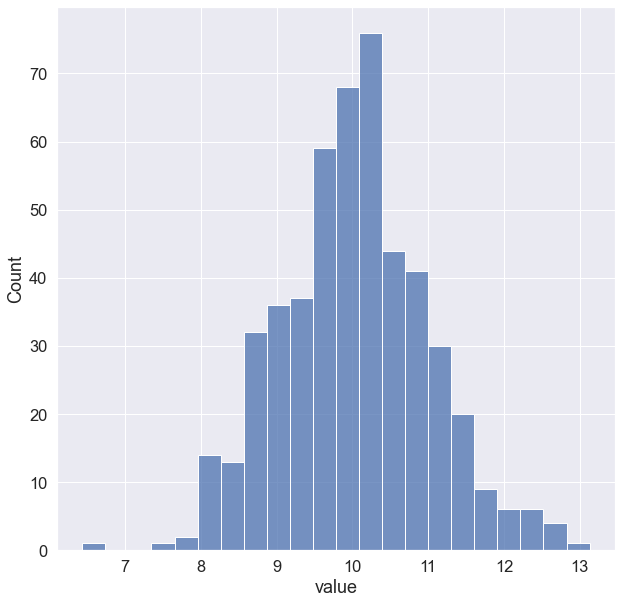

In [40]:
plt.figure(figsize=(10, 10))
sns.histplot(data=ex_data[ex_data.experimentVariant == 'Control'], x='value')

<AxesSubplot:xlabel='value', ylabel='Count'>

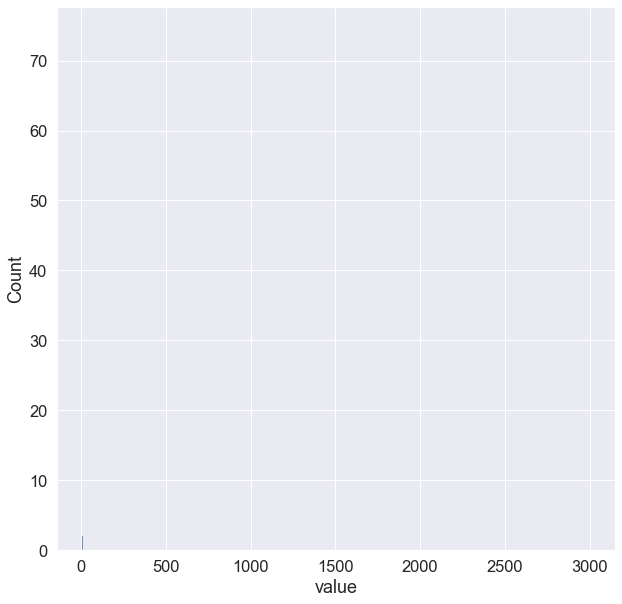

In [56]:
plt.figure(figsize=(10, 10))
sns.histplot(data=ex_data[ex_data.experimentVariant == 'Treatment'], x='value')

Проверим на выбросы

In [55]:
ex_data[ex_data.experimentVariant == 'Treatment'].query('value > 50')

,value,experimentVariant
995,1000.0,Treatment
996,1200.0,Treatment
997,1500.0,Treatment
998,2000.0,Treatment
999,3000.0,Treatment


In [57]:
ex_data[ex_data.experimentVariant == 'Treatment'].query('value < 50')

,value,experimentVariant
500,10.380495,Treatment
501,9.546867,Treatment
502,11.088215,Treatment
503,10.147274,Treatment
504,9.789808,Treatment
...,...,...
990,10.916229,Treatment
991,11.160869,Treatment
992,8.202518,Treatment
993,9.782199,Treatment


<AxesSubplot:xlabel='value', ylabel='Count'>

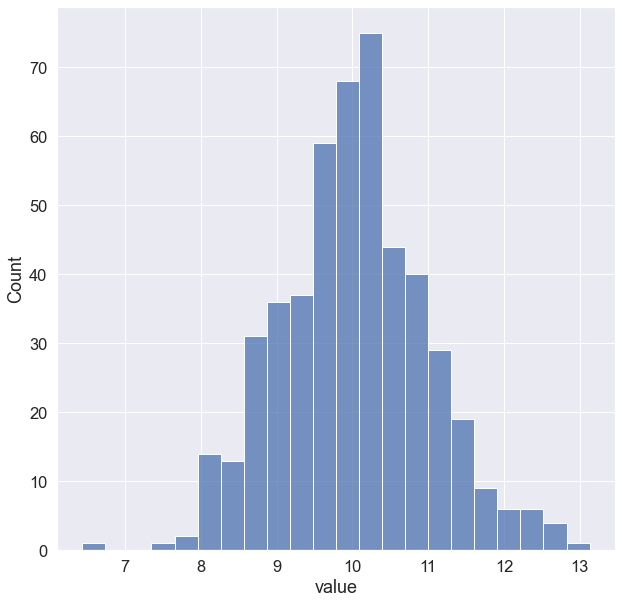

In [58]:
plt.figure(figsize=(10, 10))
sns.histplot(data=ex_data[ex_data.experimentVariant == 'Treatment'].query('value < 50'), x='value')

In [62]:
pg.normality(data=ex_data[ex_data.experimentVariant == 'Control'], method='shapiro')

,W,pval,normal
value,0.995925,0.224164,True


In [63]:
pg.normality(data=ex_data[ex_data.experimentVariant == 'Treatment'], method='shapiro')

,W,pval,normal
value,0.070389,1.093013e-43,False


In [64]:
pg.normality(data=ex_data[ex_data.experimentVariant == 'Treatment'].query('value < 50'), method='shapiro')

,W,pval,normal
value,0.995552,0.171882,True


В обеих группах одинаковое количество элементов. Распределение контрольной группы является нормальным. Распределение тестовой группы имеет 5 сильных выбросов, без них распределение нормальное.

Вырезать выбросы в данном случае скорее всего нельзя, потому что они являются значимыми и показывают результаты эксперимента.

#### Проведем t-тест

In [70]:
pg.ttest(ex_data[ex_data.experimentVariant == 'Control'].value, 
         ex_data[ex_data.experimentVariant == 'Treatment'].value)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.072902,998,two-sided,0.038438,"[-33.67, -0.92]",0.131102,0.586,0.544197


In [71]:
st.ttest_ind(a=ex_data[ex_data.experimentVariant == 'Control'].value,
             b=ex_data[ex_data.experimentVariant == 'Treatment'].value)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

По результатам t-теста имеются значимые различия между группами 

#### Проведем тест Манна-Уитни

In [74]:
st.mannwhitneyu(ex_data[ex_data.experimentVariant == 'Control'].value, 
                ex_data[ex_data.experimentVariant == 'Treatment'].value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

По результатам теста Манна-Уитни различия между группами не являются значимыми

#### Проведем бутстрап

In [82]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

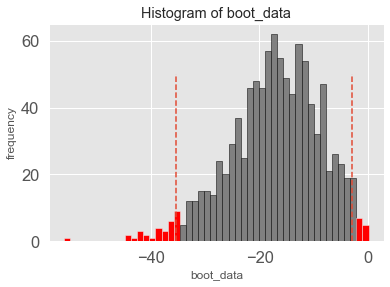

In [84]:
btsp_data = get_bootstrap(ex_data[ex_data.experimentVariant == 'Control'].value, 
              ex_data[ex_data.experimentVariant == 'Treatment'].value)

In [85]:
btsp_data['p_value']

0.03919814575493646

По результатам бутстрапа различия между группами статистически значимые

* Хорошо было бы проверить различия по дециям, это покажет где именно были получены различия

## Анализ результатов эксперимента 

T-тест и бутстрап показали, что различия между группами есть, и они статистически значимы, в то время как Критерий Манна-Уитни не показал различий между группами. 

Такие результаты обоснованы спецификой тестов. Критерий Манна-Уитни не чувствителен к выбросам, поэтому он просто проигнорировал их. Т-тест чувствителен к выбросам, но несмотря на это, показал результаты, схожие с результатами бутстрапа, которому неважна форма распределения и наличие выбросов. 

То, какой тест применять для исследования результатов эксперимента, зависит от характера выбросов:

1) Если выбросы случайны, не несут значимой информации или получены в результате неточностей исследования, то их можно вырезать и использовать t-тест, тк форма распределений позволяет это сделать. Либо использовать критерий Манна-Уитни.

2) Если выбросы значимы и несут важную (желаемую) информацию, то стоит применить бутстрап, потому что он позволяет получить много полезной информации вне зависимости от формы распределения. Использовать t-тест лучше не стоит, несмотря на то, что он показал схожие результаты 